In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

team_flights = pd.read_csv('./team_flights.csv')
fuel_prices = pd.read_csv('./fuel_prices_2101.csv',
                         index_col='date')

team_flights.head()

team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

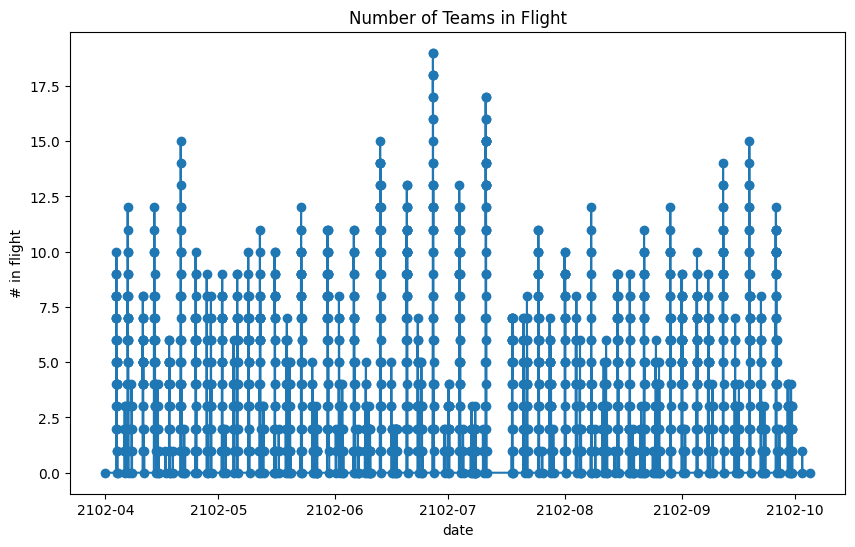

In [4]:
all_datetimes = pd.concat([team_flights['departure_datetime'], team_flights['landing_datetime']])

all_datetimes_sorted = sorted(list(set(all_datetimes)))
all_datetimes_sorted.append(pd.to_datetime('2102-04-01 00:00:00')) 
all_datetimes_sorted.append(pd.to_datetime('2102-10-05 00:00:00')) 

in_flight_df = pd.DataFrame({'date':sorted(all_datetimes_sorted),
                             'in_flight':0})

for index, flight in team_flights.iterrows():
    in_flight_df.loc[(in_flight_df['date']>=flight['departure_datetime']) &
                     (in_flight_df['date']<flight['landing_datetime']),'in_flight'] += 1

fig, ax = plt.subplots(figsize=(10, 6)) 
ax.step(in_flight_df['date'], in_flight_df['in_flight'], where='post') 
ax.scatter(in_flight_df['date'], in_flight_df['in_flight'])
ax.set_xlabel('date')
ax.set_ylabel('# in flight') 
ax.set_title('Number of Teams in Flight')
plt.show()

max_teams_in_flight = 19 

In [5]:
model = SARIMAX(fuel_prices,
              order=(1, 1, 1),             
              seasonal_order=(1, 0, 0, 7)  
              )
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=365) 

fuel_prices_forecast = pd.DataFrame(data={"date": forecast.summary_frame().index.to_timestamp(), 
                                          "price":forecast.predicted_mean.values})

team_flights['departure_date'] = team_flights['departure_datetime'].dt.date

fuel_prices_forecast['date'] = fuel_prices_forecast['date'].dt.date
fuel_prices_forecast.set_index('date', inplace=True)
merged_df = team_flights.join(fuel_prices_forecast, on='departure_date', how='left')

merged_df['fuel_cost_total'] = merged_df['price'] * merged_df['travel_distance_miles']

total_fuel_spend_2102_dollars = merged_df['fuel_cost_total'].sum()
total_fuel_spend_2102_dollars

1859792.5030258368